In [1]:
from datasets import load_dataset
from fastai.vision.all import *
from PIL import Image
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from concept_helpers.DeepView_Craft import CraftTorchDV as Craft
from concept_helpers.combined_crafts import CombinedCrafts
from xplique.attributions.global_sensitivity_analysis import HaltonSequenceRS, JansenEstimator
from xplique.concepts.craft_torch import _batch_inference
from torchvision import transforms
from sklearn.decomposition import NMF
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from fastai.data.external import untar_data, URLs

from Uncertainty_Functions.unc_functions import uncertainty_matrices, entropy_uncertainty
from experiment_helpers.experiment_helper_functions import *



import numpy as np
import itertools
import matplotlib.pyplot as plt
import random
import torchvision.transforms.functional as F
import urllib.request
import glob
import torch
import torch.nn as nn
import timm



device = 'cuda' 
# loading any timm model
model = timm.create_model('nf_resnet50.ra2_in1k', pretrained=True)
model = model.to(device)

# processing
config = resolve_data_config({}, model=model)
transform = create_transform(**config)
to_pil = transforms.ToPILImage()

# cut the model in twop arts (as explained in the paper)
# first part is g(.) our 'input_to_latent' model, second part is h(.) our 'latent_to_logit' model
g = nn.Sequential(*(list(model.children())[:4]))  # input to penultimate layer
h = nn.Sequential(*(list(model.children())[4:]))


# Load ImageNet class names
with urllib.request.urlopen('https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt') as f:
    imagenet_class_names = np.array(f.read().decode('utf-8').split('\n'))

def get_validation_set_for_random_classes(preprocess_fn, gen_images, transform, to_pil, seed=None):
    """
    Randomly selects 10 classes from Imagewoof and Imagenette, retrieves their validation images and labels.

    Args:
        preprocess_fn (function): Function to preprocess images in batches.
        gen_images: Data generator function.
        transform: Transform function for images.
        to_pil: Function to convert images to PIL format.
        seed (int, optional): Random seed for reproducibility. Default is None.

    Returns:
        val_images (list): Preprocessed validation images for the selected classes.
        val_labels (list): Corresponding class labels (ImageNet indices).
        selected_classes (list): Names of the 10 randomly selected classes.
    """

    if seed is not None:
        random.seed(seed)
    
    def gen_images(filelist):
        for f in filelist:
            folder_name = f.split('/')[-2]
            class_id = folder_name2class_id[folder_name]
            im = Image.open(f)
            if len(im.getbands()) == 3:
                yield np.array(im.resize((224, 224))), class_id

    # Download datasets
    imagewoof_folder = untar_data(URLs.IMAGEWOOF_160)
    imagenette_folder = untar_data(URLs.IMAGENETTE_160)

    # Define Imagewoof class mappings
    imagewoof_folders = ['n02086240', 'n02087394', 'n02088364', 'n02089973', 'n02093754', 
                          'n02096294', 'n02099601', 'n02105641', 'n02111889', 'n02115641']
    imagewoof_names = ['Shih-Tzu', 'Rhodesian ridgeback', 'beagle', 'English foxhound', 'Border terrier',
                       'Australian terrier', 'golden retriever', 'Old English sheepdog', 'Samoyed', 'dingo']
    
    imagenette_folders = ['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079',
                           'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']
    imagenette_names = ['tench', 'English springer', 'cassette player', 'chain saw', 'church', 
                        'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']
    
    # Get ImageNet class IDs
    imagewoof_class_ids = [np.where(imagenet_class_names == class_name)[0][0] for class_name in imagewoof_names]
    imagenette_class_ids = [np.where(imagenet_class_names == class_name)[0][0] for class_name in imagenette_names]

    # Combine all classes
    all_folders = imagewoof_folders + imagenette_folders
    all_class_names = imagewoof_names + imagenette_names
    all_class_ids = imagewoof_class_ids + imagenette_class_ids
    
    # Create folder name to class ID mapping
    folder_name2class_id = dict(zip(all_folders, all_class_ids))
    
    # Randomly select 10 classes
    selected_indices = random.sample(range(20), 10)
    selected_folders = [all_folders[i] for i in selected_indices]
    selected_class_names = [all_class_names[i] for i in selected_indices]
    selected_class_ids = [all_class_ids[i] for i in selected_indices]  # Ensure correct ImageNet labels

    # Collect validation file paths
    val_filelist = []
    for folder in selected_folders:
        val_filelist.extend(glob.glob(f'{imagewoof_folder}/val/{folder}/*.JPEG'))
        val_filelist.extend(glob.glob(f'{imagenette_folder}/val/{folder}/*.JPEG'))

    # Process images and labels
    val_images, val_labels = preprocess_fn(val_filelist, gen_images, transform, to_pil)

    return val_images, val_labels, selected_class_names, selected_class_ids





def gen_images(filelist,folder_names,folder_name2class_id):
        for f in filelist:
            
            folder_name = f.split('/')[-2]
            if folder_name in folder_names:
                class_id = folder_name2class_id[folder_name]
                im = Image.open(f)
                if len(im.getbands()) == 3:
                    yield np.array(im.resize((224, 224))), class_id

ood_folder = '/home/iroberts/projects/concepts_deepview/data/ninco_all/NINCO/NINCO_OOD_classes'
        
ood_folder_names = os.listdir(ood_folder)
ood_class_names = ood_folder_names

ood_class_ids = [i+1000 for i,class_name in enumerate(ood_class_names)]
ood_folder_name2class_id = dict(zip(ood_folder_names, ood_class_ids))
ood_filelist = glob.glob(f'{ood_folder}/*/*.jpg')

ood_images, ood_labels = zip(*gen_images(ood_filelist,ood_folder_names,ood_folder_name2class_id))
ood_images, ood_labels = np.array(ood_images), np.array(ood_labels)
ood_preprocessed_images = torch.stack([transform(to_pil(img)) for img in ood_images], 0)

def full_wrapper(x):
    with torch.no_grad():
        x = np.array(x, dtype=np.float32)
        tensor = torch.from_numpy(x).to(device)
        latent = g(tensor)
        pred = h(latent).cpu().numpy()
    return pred
    
def latent_wrapper(x):
    with torch.no_grad():
        x = np.array(x, dtype=np.float32)
        tensor = torch.from_numpy(x).to(device)
        latent = g(tensor).cpu().numpy()
            # pred = h(tensor).cpu().numpy()
    return latent

def process_in_batches(data, batch_size, func):
    """
    Process data in batches using the full_wrapper function.

    Args:
        data (np.ndarray): Input data to process.
        batch_size (int): Size of each batch.

    Returns:
        np.ndarray: Predictions for the entire dataset.
    """
    # Initialize an empty list to store predictions
    all_preds = []

    # Iterate over the data in batches
    for start_idx in range(0, len(data), batch_size):
        # Get the end index for the current batch
        end_idx = min(start_idx + batch_size, len(data))
        # Get the current batch
        batch = data[start_idx:end_idx]
        # Use full_wrapper to process the batch and get predictions
        batch_preds = func(batch)
        # Append the predictions to the list
        all_preds.append(batch_preds)

    # Concatenate all batch predictions into a single numpy array
    all_preds = np.concatenate(all_preds, axis=0)
    return all_preds
    
def predict_with_uncertainty_batched(f_model, data_loader, n_iter=10, device="cpu"):
    """
    Perform N stochastic forward passes over batches of data and return predictions.

    Args:
        f_model (nn.Module): The model with dropout layers.
        data_loader (DataLoader): DataLoader for the dataset.
        n_iter (int): Number of stochastic forward passes.
        device (str): Device to perform computations on ('cpu' or 'cuda').

    Returns:
        torch.Tensor: Predictions of shape (n_iter, num_data, num_classes).
    """
    # f_model.train()  # Ensure dropout is active during inference
    
    # Store predictions for all iterations
    all_preds = []
    for _ in range(n_iter):
        preds = []
        for inputs,_ in data_loader:
            with torch.no_grad():
                batch_preds = torch.softmax(f_model(inputs),dim=1)
                
            preds.append(batch_preds)
        # Concatenate predictions for this iteration
        all_preds.append(torch.cat(preds, dim=0))
    
    # Stack predictions across iterations
    return torch.stack(all_preds, dim=0)
    

def compute_predictions_sigmoid(inputs):
    inputs = inputs.to(device)
    data_loader = torch.utils.data.DataLoader(inputs, batch_size=64)
    
    predictions = predict_with_uncertainty_batched_sig(stochastic_model, data_loader, n_iter=20, device=device)

    predictions =  predictions.cpu().numpy()
    
    a,prob_mat = uncertainty_matrices(predictions)
    t,e,a = entropy_uncertainty(prob_mat)
    sig_threshold, _, t_norm = get_threshold(t)
    loc = UncertaintyWrapperWithSigmoid(sig_threshold)

    unc_pred_probs = loc.predict_proba(t_norm)
    unc_preds = np.argmax(unc_pred_probs, axis=1)
    return unc_preds, unc_pred_probs





2025-02-26 02:17:57.855801: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
from tqdm import tqdm
# Initialize a dictionary to store results
results = defaultdict(lambda: defaultdict(dict))
auc_results = defaultdict(lambda: defaultdict(dict))
ood_results = defaultdict(lambda: defaultdict(dict))
# Run multiple times and collect results

for i in tqdm(range(20)):

    val_images, val_labels, selected_classes, selected_ids = get_validation_set_for_random_classes(
    preprocess_images_in_batches, gen_images, transform, to_pil,seed=None)
    
    ood_sample = np.random.choice(len(ood_preprocessed_images),200,False)
    sample_ood_preprocessed_images = ood_preprocessed_images[ood_sample]
    sample_ood_labels = ood_labels[ood_sample]
    
    sample = np.random.choice(len(val_images),800,False )
    sample_val_images = val_images[sample]
    sample_val_labels = val_labels[sample]
    

    

    
    # Step 3: Concatenate IID and OOD data
    idd_embeddings = process_in_batches(sample_val_images, 32, latent_wrapper)
    
    ood_embeddings = process_in_batches(sample_ood_preprocessed_images, 32, latent_wrapper)
    
    all_embeddings = torch.cat([torch.from_numpy(idd_embeddings),torch.from_numpy(ood_embeddings)]).to(device)
    all_images = torch.cat([sample_val_images, sample_ood_preprocessed_images]).to(device)
    all_labels = torch.from_numpy(np.concatenate([sample_val_labels, sample_ood_labels])).to(device)
    
    # Step 5: Shuffle all data while keeping track of noise
    shuffle_indices = torch.randperm(all_images.shape[0])
    
    shuffled_embeddings = all_embeddings[shuffle_indices]
    shuffled_images = all_images[shuffle_indices]
    shuffled_labels = all_labels[shuffle_indices]
    
    idd_odd_og_labels = shuffled_labels.cpu().numpy()
    
    
    ood_ind = np.where(idd_odd_og_labels > 999)[0]
    idd_ind = np.where(idd_odd_og_labels <= 999)[0]
    
    idd_odd_labels = idd_odd_og_labels.copy()
    idd_odd_labels[ood_ind] = np.random.choice(np.unique(val_labels), size=len(ood_ind))
    gt_idd_ood = idd_odd_og_labels.copy()
    gt_idd_ood[ood_ind] = 1
    gt_idd_ood[idd_ind] = 0
    
    
    idd_odd_labels = torch.from_numpy(idd_odd_labels).to(device)
    dataset = EmbeddingDataset(shuffled_embeddings,idd_odd_labels)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=8)
    
    # Create stochastic model
    dropout_prob = 0.5
    stochastic_model = StochasticModel(h, dropout_prob).to(device)
    
    
    predictions = predict_with_uncertainty_batched(stochastic_model.to(device), dataloader, n_iter=30)
    predictions = predictions.cpu().numpy()
    
    
    prediction_list, prob_mat = uncertainty_matrices(predictions)
    t, e, a = entropy_uncertainty(prob_mat)
    var = 1 -  np.mean(((np.full((prob_mat.shape[0],1000),.001) - np.mean(prob_mat,axis=1))**2), axis=1)
                
    kl = 1 - (kl_divergence(np.mean(prob_mat,axis=1), np.full((prob_mat.shape[0],1000),.001),axis=1) / np.log(1000))

    from sklearn.mixture import GaussianMixture

    t_min, t_max = np.min(t), np.max(t)
    # Add a small epsilon to ensure values are strictly within (0, 1)
    epsilon = 1e-6
    t_normalized = (t - t_min) / (t_max - t_min)
    t_norm = np.clip(t_normalized, epsilon, 1 - epsilon)
    
    data = t_norm
    # Gaussian Mixture Model to estimate clusters
    gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
    data_reshaped = data.reshape(-1, 1)
    gmm.fit(data_reshaped)
    labels = gmm.predict(data_reshaped)


    cluster_data0 = data[labels == 0]
    cluster_data1 = data[labels == 1]

    if np.mean(cluster_data0) > np.mean(cluster_data1):
        mini = np.min(cluster_data0) 
        maxi = np.max(cluster_data1) 
        threshold = (mini + maxi) / 2
    if np.mean(cluster_data1) > np.mean(cluster_data0):
        mini = np.min(cluster_data1) 
        maxi = np.max(cluster_data0) 
        threshold = (mini + maxi) / 2
    
    
    loc = UncertaintyWrapperWithSigmoid(threshold)
    unc_pred_probs = loc.predict_proba(t_norm)
    unc_preds = np.argmax(unc_pred_probs, axis=1)
    
    low_indices = np.where(unc_preds == 0)[0]
    med_indices = np.where(unc_preds == 1)[0]
    
    patch_size=80
    
    
    med_fit = Craft(input_to_latent_model=g,
                        latent_to_logit_model=h,
                        number_of_concepts=35,
                        # labels=h_y,
                        patch_size=patch_size,
                        batch_size=64,
                        device=device)
    print("Fitting Unsupervised Craft....")
    med_crops, med_crops_u, med_w = med_fit.fit(shuffled_images[med_indices])

    low_fit = Craft(input_to_latent_model=g,
                            latent_to_logit_model=h,
                            number_of_concepts=55,
                            # labels=h_y,
                            patch_size=patch_size,
                            batch_size=64,
                            device=device)
    print("Fitting Unsupervised Craft....")
    low_crops, low_crops_u,low_w = low_fit.fit(shuffled_images[low_indices])
    
    unc_basis = np.vstack([low_w,med_w])
    
    
    sigmoidunc_craft = CombinedCrafts(input_to_latent_model=g,
                    latent_to_logit_model=stochastic_model,
                    number_of_concepts=len(unc_basis),
                    inputs=shuffled_images,
                    labels=unc_preds,
                    basis = unc_basis,
                    batch_size=64,
                    patch_size=patch_size,
                    device=device)
    print("Fitting Craft....")
    sigmoidunc_craft.transform_all()
    
    
        
    sig_imp, sig_im_imp = estimate_importance_sigmoid(sigmoidunc_craft,compute_predictions_sigmoid,unc_basis,shuffled_embeddings)
    
    sig_im_nmf_act = np.array([nmf_transform(torch.unsqueeze(image,dim=0).permute((0,2,3,1)).cpu().numpy(),unc_basis) 
                               for i,image in enumerate(shuffled_embeddings)])
    sig_im_nmf_act =  sig_im_nmf_act.reshape((len(sig_im_nmf_act), sig_im_nmf_act.shape[2]))

    # unc_imp_val = np.mean(sig_im_nmf_act[med_indices], axis=0)
    # cer_imp_val = np.mean(sig_im_nmf_act[low_indices], axis=0)
    # unc_imp = np.argsort(unc_imp_val)[::-1]
    # cer_imp = np.argsort(cer_imp_val)[::-1]

    # for k,vals in enumerate([cer_imp_val,unc_imp_val]):
    #     most_important_concepts = np.argsort(vals)[::-1]
    #     sigmoidunc_craft.sensitivities[k] = Sensitivity(vals, most_important_concepts,
    #                                                                   cmaps=plt.get_cmap('tab20b').colors
    #                                                                         + plt.get_cmap('Set3').colors +
    #                                                                         plt.get_cmap('tab20c').colors +
    #                                                                         plt.get_cmap('tab10').colors +
    #                                                                         plt.get_cmap('tab20').colors +
    #                                                                         plt.get_cmap('Set1').colors +
    #                                                                         plt.get_cmap('Set2').colors)
    
    _, y_preds_sig = compute_predictions_sigmoid(shuffled_embeddings)



    step_length=90
    
    
    t_acc, _, _, _ ,t_odd, steps=accuracy_rejection(prediction_list, 
                                                           idd_odd_labels,
                                              gt_idd_ood,
                                                           t, 
                                                           step_length=step_length,
                                                           plot=False, 
                                                           plot_name= "test")

    try: 
        e_acc, _, _, _ ,e_odd, steps = accuracy_rejection(prediction_list, 
                                                                idd_odd_labels,
                                                    gt_idd_ood,
                                                                e, 
                                                                step_length=step_length,
                                                                plot=False, 
                                                                plot_name= "test")
        
        a_acc, _, _, _ , a_odd, steps=accuracy_rejection(prediction_list, 
                                                                idd_odd_labels,
                                                  gt_idd_ood,
                                                               a, 
                                                              step_length=step_length,
                                                               plot=False, 
                                                               plot_name= "test")
    except:
        e_acc = None
        a_acc = None
        
    var_acc, _, _, _ ,var_odd, steps=accuracy_rejection(prediction_list, 
                                                           idd_odd_labels,
                                                gt_idd_ood,
                                                           var, 
                                                           step_length=step_length,
                                                           plot=False, 
                                                           plot_name= "test")
    
    kl_acc, _, _, _ , kl_odd, steps=accuracy_rejection(prediction_list, 
                                                           idd_odd_labels,
                                               gt_idd_ood,
                                                           kl, 
                                                           step_length=step_length,
                                                           plot=False, 
                                                           plot_name= "test")
    sig_preds_acc, _, _, _ , sig_preds_odd, steps=accuracy_rejection(prediction_list, 
                                                            idd_odd_labels,
                                                      gt_idd_ood,
                                                           y_preds_sig[:,1], 
                                                            step_length=step_length,
                                                           plot=False, 
                                                           plot_name= "test")
    
    num = 1
    sig_local_softimp_weighted = np.array(local_imp_concepts_weighted_soft(sigmoidunc_craft, sig_im_imp,num,y_preds_sig))
    sig_local_softnmf_weighted = np.array(local_imp_concepts_weighted_soft(sigmoidunc_craft, sig_im_nmf_act,num,y_preds_sig ))
    # sig_local_softactpreds = np.array(local_imp_concepts_globally_lsoft(sigmoidunc_craft,nmf_activations ,num,y_preds_sig))
    num = 1
    sig_local_hardimp_weighted = np.array(local_imp_concepts_weighted_hard(sigmoidunc_craft, sig_im_imp,num,y_preds_sig))
    sig_local_hardnmf_weighted = np.array(local_imp_concepts_weighted_hard(sigmoidunc_craft, sig_im_nmf_act,num,y_preds_sig ))
   
    num = 2
    sig_2local_hardimp_weighted = np.array(local_imp_concepts_weighted_hard(sigmoidunc_craft, sig_im_imp,num,y_preds_sig))
    sig_2local_hardnmf_weighted = np.array(local_imp_concepts_weighted_hard(sigmoidunc_craft, sig_im_nmf_act,num,y_preds_sig ))

    num=2
    sig_2local_softimp_weighted = np.array(local_imp_concepts_weighted_soft(sigmoidunc_craft, sig_im_imp,num,y_preds_sig))
    sig_2local_softnmf_weighted = np.array(local_imp_concepts_weighted_soft(sigmoidunc_craft, sig_im_nmf_act,num,y_preds_sig))
    
    num = 3
    sig_3local_hardimp_weighted = np.array(local_imp_concepts_weighted_hard(sigmoidunc_craft, sig_im_imp,num,y_preds_sig))
    sig_3local_hardnmf_weighted = np.array(local_imp_concepts_weighted_hard(sigmoidunc_craft, sig_im_nmf_act,num,y_preds_sig ))
    
    num=3
    sig_3local_softimp_weighted = np.array(local_imp_concepts_weighted_soft(sigmoidunc_craft, sig_im_imp,num,y_preds_sig))
    sig_3local_softnmf_weighted = np.array(local_imp_concepts_weighted_soft(sigmoidunc_craft, sig_im_nmf_act,num,y_preds_sig))
    

    one_local_soft_imp, _, _, _ , one_local_soft_imp_odd,steps=accuracy_rejection(prediction_list, 
                                                            idd_odd_labels,
                                                           gt_idd_ood,
                                                           sig_local_softimp_weighted, 
                                                           plot=False, 
                                                           step_length=step_length,
                                                           plot_name= "test")
    one_local_soft_nmf, _, _, _ ,one_local_soft_nmf_odd, steps=accuracy_rejection(prediction_list, 
                                                            idd_odd_labels,
                                                           gt_idd_ood,
                                                           sig_local_softnmf_weighted, 
                                                           step_length=step_length,
                                                           plot=False, 
                                                           plot_name= "test")
    
    one_local_hard_imp, _, _, _ , one_local_hard_imp_odd,steps=accuracy_rejection(prediction_list, 
                                                            idd_odd_labels,
                                                           gt_idd_ood,
                                                           sig_local_hardimp_weighted, 
                                                           step_length=step_length,
                                                           plot=False, 
                                                           plot_name= "test")
    one_local_hard_nmf, _, _, _ ,one_local_hard_nmf_odd, steps=accuracy_rejection(prediction_list, 
                                                            idd_odd_labels,
                                                           gt_idd_ood,
                                                           sig_local_hardnmf_weighted, 
                                                           step_length=step_length,
                                                           plot=False, 
                                                           plot_name= "test")
    
    two_local_soft_imp, _, _, _ ,two_local_soft_imp_odd, steps=accuracy_rejection(prediction_list, 
                                                            idd_odd_labels,
                                                           gt_idd_ood,
                                                           sig_2local_softimp_weighted, 
                                                        step_length=step_length,
                                                       plot=False, 
                                                       plot_name= "test")
    two_local_hard_imp, _, _, _ ,two_local_hard_imp_odd, steps=accuracy_rejection(prediction_list, 
                                                            idd_odd_labels,
                                                           gt_idd_ood,
                                                           sig_2local_hardimp_weighted, 
                                                        step_length=step_length,
                                                       plot=False, 
                                                       plot_name= "test")

    two_local_hard_nmf, _, _, _ ,two_local_hard_nmf_odd, steps=accuracy_rejection(prediction_list, 
                                                        idd_odd_labels,
                                                           gt_idd_ood,
                                                       sig_2local_hardnmf_weighted, 
                                                           step_length=step_length,
                                                       plot=False, 
                                                           plot_name= "test")
    two_local_soft_nmf, _, _, _ ,two_local_soft_nmf_odd, steps=accuracy_rejection(prediction_list, 
                                                            idd_odd_labels,
                                                           gt_idd_ood,
                                                           sig_2local_softnmf_weighted, 
                                                           step_length=step_length,
                                                           plot=False, 
                                                           plot_name= "test")
    three_local_hard_imp, _, _, _ ,three_local_hard_imp_odd, steps=accuracy_rejection(prediction_list, 
                                                            idd_odd_labels,
                                                             gt_idd_ood,
                                                           sig_3local_hardimp_weighted, 
                                                             step_length=step_length,
                                                           plot=False, 
                                                           plot_name= "test")
    three_local_hard_nmf, _, _, _ ,three_local_hard_nmf_odd, steps=accuracy_rejection(prediction_list, 
                                                            idd_odd_labels,
                                                             gt_idd_ood,
                                                           sig_3local_hardnmf_weighted, 
                                                             step_length=step_length,
                                                           plot=False, 
                                                           plot_name= "test")
    three_local_soft_imp, _, _, _ ,three_local_soft_imp_odd, steps=accuracy_rejection(prediction_list, 
                                                            idd_odd_labels,
                                                             gt_idd_ood,
                                                           sig_3local_softimp_weighted,
                                                             step_length=step_length,
                                                           plot=False, 
                                                           plot_name= "test")
    three_local_soft_nmf, _, _, _ ,three_local_soft_nmf_odd, steps=accuracy_rejection(prediction_list, 
                                                            idd_odd_labels,
                                                             gt_idd_ood,
                                                           sig_3local_softnmf_weighted, 
                                                             step_length=step_length,
                                                           plot=False, 
                                                           plot_name= "test")
    
    num = 5
    sig_5local_hardimp_weighted = np.array(local_imp_concepts_weighted_hard(sigmoidunc_craft, sig_im_imp,num,y_preds_sig))
    sig_5local_hardnmf_weighted = np.array(local_imp_concepts_weighted_hard(sigmoidunc_craft, sig_im_nmf_act,num,y_preds_sig ))
    
    num=5
    sig_5local_softimp_weighted = np.array(local_imp_concepts_weighted_soft(sigmoidunc_craft, sig_im_imp,num,y_preds_sig))
    sig_5local_softnmf_weighted = np.array(local_imp_concepts_weighted_soft(sigmoidunc_craft, sig_im_nmf_act,num,y_preds_sig))
    
    
    
    
    five_local_hard_imp, _, _, _ ,five_local_hard_imp_odd, steps=accuracy_rejection(prediction_list, 
                                                            idd_odd_labels,
                                                            gt_idd_ood,
                                                           sig_5local_hardimp_weighted, 
                                                            step_length=step_length,
                                                           plot=False, 
                                                           plot_name= "test")
    five_local_hard_nmf, _, _, _ ,five_local_hard_nmf_odd, steps=accuracy_rejection(prediction_list, 
                                                            idd_odd_labels,
                                                            gt_idd_ood,
                                                           sig_5local_hardnmf_weighted, 
                                                            step_length=step_length,
                                                           plot=False, 
                                                           plot_name= "test")
    
    five_local_soft_imp, _, _, _ ,five_local_soft_imp_odd, steps=accuracy_rejection(prediction_list, 
                                                            idd_odd_labels,
                                                            gt_idd_ood,
                                                           sig_5local_softimp_weighted, 
                                                            step_length=step_length,
                                                           plot=False, 
                                                           plot_name= "test")
    
    five_local_soft_nmf, _, _, _ , five_local_soft_nmf_odd, steps=accuracy_rejection(prediction_list, 
                                                            idd_odd_labels,
                                                            gt_idd_ood,
                                                           sig_5local_softnmf_weighted, 
                                                            step_length=step_length,
                                                           plot=False, 
                                                           plot_name= "test")

    num = 1
    sig_local_imp_raw = np.array(local_imp_concepts_raw_soft(sigmoidunc_craft, sig_im_imp,num,y_preds_sig))
    sig_local_nmf_raw = np.array(local_imp_concepts_raw_soft(sigmoidunc_craft, sig_im_nmf_act,num,y_preds_sig ))
    # sig_local_softactpreds = np.array(local_imp_concepts_globally_lsoft(sigmoidunc_craft,nmf_activations ,num,y_preds_sig))
   

    num=2
    sig_2local_imp_raw = np.array(local_imp_concepts_raw_soft(sigmoidunc_craft, sig_im_imp,num,y_preds_sig))
    sig_2local_nmf_raw = np.array(local_imp_concepts_raw_soft(sigmoidunc_craft, sig_im_nmf_act,num,y_preds_sig ))
    
    
    num=3
    sig_3local_imp_raw = np.array(local_imp_concepts_raw_soft(sigmoidunc_craft, sig_im_imp,num,y_preds_sig))
    sig_3local_nmf_raw = np.array(local_imp_concepts_raw_soft(sigmoidunc_craft, sig_im_nmf_act,num,y_preds_sig ))
    

    one_local_imp_raw, _, _, _ , one_local_imp_raw_odd, steps=accuracy_rejection(prediction_list, 
                                                            idd_odd_labels,
                                                           gt_idd_ood,
                                                           sig_local_imp_raw, 
                                                          step_length=step_length,
                                                           plot=False, 
                                                           plot_name= "test")
    one_local_nmf_raw, _, _, _ ,one_local_nmf_raw_odd, steps=accuracy_rejection(prediction_list, 
                                                            idd_odd_labels,
                                                          gt_idd_ood,
                                                           sig_local_nmf_raw, 
                                                          step_length=step_length,
                                                           plot=False, 
                                                           plot_name= "test")
    
    
    two_local_imp_raw, _, _, _ ,two_local_imp_raw_odd, steps=accuracy_rejection(prediction_list, 
                                                            idd_odd_labels,
                                                          gt_idd_ood,
                                                           sig_2local_imp_raw, 
                                                          step_length=step_length,
                                                           plot=False, 
                                                           plot_name= "test")
    two_local_nmf_raw, _, _, _ , two_local_nmf_raw_odd,steps=accuracy_rejection(prediction_list, 
                                                            idd_odd_labels,
                                                          gt_idd_ood,
                                                           sig_2local_nmf_raw, 
                                                          step_length=step_length,
                                                           plot=False, 
                                                           plot_name= "test")
  
    three_local_imp_raw, _, _, _ ,three_local_imp_raw_odd, steps=accuracy_rejection(prediction_list, 
                                                            idd_odd_labels,
                                                            gt_idd_ood,
                                                           sig_3local_imp_raw, 
                                                            step_length=step_length,
                                                           plot=False, 
                                                           plot_name= "test")
    three_local_nmf_raw, _, _, _ , three_local_nmf_raw_odd,steps=accuracy_rejection(prediction_list, 
                                                            idd_odd_labels,
                                                            gt_idd_ood,
                                                           sig_3local_nmf_raw, 
                                                            step_length=step_length,
                                                           plot=False, 
                                                           plot_name= "test")
    
    num = 5
    sig_5local_imp_raw = np.array(local_imp_concepts_raw_soft(sigmoidunc_craft, sig_im_imp,num,y_preds_sig))
    sig_5local_nmf_raw = np.array(local_imp_concepts_raw_soft(sigmoidunc_craft, sig_im_nmf_act,num,y_preds_sig  ))
    
    num=3
    sig_3global_imp_raw = np.array(global_imp_concepts_raw_soft(sigmoidunc_craft, sig_im_imp,num,y_preds_sig))
    sig_3global_nmf_raw = np.array(global_imp_concepts_raw_soft(sigmoidunc_craft, sig_im_nmf_act,num,y_preds_sig ))

    num=5
    sig_5global_imp_raw = np.array(global_imp_concepts_raw_soft(sigmoidunc_craft, sig_im_imp,num,y_preds_sig))
    sig_5global_nmf_raw = np.array(global_imp_concepts_raw_soft(sigmoidunc_craft, sig_im_nmf_act,num,y_preds_sig ))
    
    
    
    five_local_imp_raw, _, _, _ ,five_local_imp_raw_odd, steps=accuracy_rejection(prediction_list, 
                                                            idd_odd_labels,
                                                           gt_idd_ood,
                                                           sig_5local_imp_raw, 
                                                           step_length=step_length,
                                                           plot=False, 
                                                           plot_name= "test")
    five_local_nmf_raw, _, _, _ , five_local_nmf_raw_odd,steps=accuracy_rejection(prediction_list, 
                                                            idd_odd_labels,
                                                           gt_idd_ood,
                                                           sig_5local_nmf_raw, 
                                                           step_length=step_length,
                                                           plot=False, 
                                                           plot_name= "test")
    
    three_global_imp_raw, _, _, _ ,three_global_imp_raw_odd, steps=accuracy_rejection(prediction_list, 
                                                            idd_odd_labels,
                                                             gt_idd_ood,
                                                           sig_3global_imp_raw, 
                                                             step_length=step_length,
                                                           plot=False, 
                                                           plot_name= "test")
    
    three_global_nmf_raw, _, _, _ , three_global_nmf_raw_odd,steps=accuracy_rejection(prediction_list, 
                                                            idd_odd_labels,
                                                             gt_idd_ood,
                                                           sig_3global_nmf_raw, 
                                                             step_length=step_length,
                                                           plot=False, 
                                                           plot_name= "test")

    five_global_imp_raw, _, _, _ , five_global_imp_raw_odd,steps=accuracy_rejection(prediction_list, 
                                                            idd_odd_labels,
                                                            gt_idd_ood,
                                                           sig_5global_imp_raw, 
                                                            step_length=step_length,
                                                           plot=False, 
                                                           plot_name= "test")
    
    five_global_nmf_raw, _, _, _ ,five_global_nmf_raw_odd,  steps=accuracy_rejection(prediction_list, 
                                                            idd_odd_labels,
                                                            gt_idd_ood,
                                                           sig_5global_nmf_raw, 
                                                            step_length=step_length,
                                                           plot=False, 
                                                           plot_name= "test")
    
    
    # Log results for the current iteration
    results[i] = {
        "total": np.array(t_acc),
        "epistemic": np.array(e_acc),
        "aleatoric": np.array(a_acc), 
        "var": np.array(var_acc),
        "kl": np.array(kl_acc),
        
        
        "sigmoid-mapping": np.array(sig_preds_acc),
        "soft_weighted-local-1-imp": np.array(one_local_soft_imp), 
        "soft_weighted-local-1-nmf": np.array(one_local_soft_nmf),
        "soft_weighted-local-2-imp": np.array(two_local_soft_imp),
        "soft_weighted-local-2-nmf": np.array(two_local_soft_nmf), 
        "soft_weighted-local-3-imp": np.array(three_local_soft_imp),
        "soft_weighted-local-3-nmf": np.array(three_local_soft_nmf),
        "soft_weighted-local-5-imp": np.array(five_local_soft_imp),
        "soft_weighted-local-5-nmf": np.array(five_local_soft_nmf),
        "hard_weighted-local-1-imp": np.array(one_local_hard_imp), 
        "hard_weighted-local-1-nmf": np.array(one_local_hard_nmf),
        "hard_weighted-local-2-imp": np.array(two_local_hard_imp),
        "hard_weighted-local-2-nmf": np.array(two_local_hard_nmf), 
        "hard_weighted-local-3-imp": np.array(three_local_hard_imp),
        "hard_weighted-local-3-nmf": np.array(three_local_hard_nmf),
        "hard_weighted-local-5-imp": np.array(five_local_hard_imp),
        "hard_weighted-local-5-nmf": np.array(five_local_hard_nmf),
        
        "raw-local-1-imp": np.array(one_local_imp_raw), 
        "raw-local-1-nmf": np.array(one_local_nmf_raw),
        "raw-local-2-imp": np.array(two_local_imp_raw),
        "raw-local-2-nmf": np.array(two_local_nmf_raw), 
        "raw-local-3-imp": np.array(three_local_imp_raw),
        "raw-local-3-nmf": np.array(three_local_nmf_raw),
        "raw-local-5-imp": np.array(five_local_imp_raw),
        "raw-local-5-nmf": np.array(five_local_nmf_raw),
        "raw-global-3-imp": np.array(three_global_imp_raw), 
        "raw-global-3-nmf": np.array(three_global_nmf_raw),
        "raw-global-5-imp": np.array(five_global_imp_raw),
        "raw-global-5-nmf": np.array(five_global_nmf_raw), 
        
        
        
    }  
    ood_results[i] = {
        "total": np.array(t_odd),
        "epistemic": np.array(e_odd),
        "aleatoric": np.array(a_odd), 
        "var": np.array(var_odd),
        "kl": np.array(kl_odd),
        
        
        "sigmoid-mapping": np.array(sig_preds_odd),
        "soft_weighted-local-1-imp": np.array(one_local_soft_imp_odd), 
        "soft_weighted-local-1-nmf": np.array(one_local_soft_nmf_odd),
        "soft_weighted-local-2-imp": np.array(two_local_soft_imp_odd),
        "soft_weighted-local-2-nmf": np.array(two_local_soft_nmf_odd), 
        "soft_weighted-local-3-imp": np.array(three_local_soft_imp_odd),
        "soft_weighted-local-3-nmf": np.array(three_local_soft_nmf_odd),
        "soft_weighted-local-5-imp": np.array(five_local_soft_imp_odd),
        "soft_weighted-local-5-nmf": np.array(five_local_soft_nmf_odd),
        "hard_weighted-local-1-imp": np.array(one_local_hard_imp_odd), 
        "hard_weighted-local-1-nmf": np.array(one_local_hard_nmf_odd),
        "hard_weighted-local-2-imp": np.array(two_local_hard_imp_odd),
        "hard_weighted-local-2-nmf": np.array(two_local_hard_nmf_odd), 
        "hard_weighted-local-3-imp": np.array(three_local_hard_imp_odd),
        "hard_weighted-local-3-nmf": np.array(three_local_hard_nmf_odd),
        "hard_weighted-local-5-imp": np.array(five_local_hard_imp_odd),
        "hard_weighted-local-5-nmf": np.array(five_local_hard_nmf_odd),
        
        "raw-local-1-imp": np.array(one_local_imp_raw_odd), 
        "raw-local-1-nmf": np.array(one_local_nmf_raw_odd),
        "raw-local-2-imp": np.array(two_local_imp_raw_odd),
        "raw-local-2-nmf": np.array(two_local_nmf_raw_odd), 
        "raw-local-3-imp": np.array(three_local_imp_raw_odd),
        "raw-local-3-nmf": np.array(three_local_nmf_raw_odd),
        "raw-local-5-imp": np.array(five_local_imp_raw_odd),
        "raw-local-5-nmf": np.array(five_local_nmf_raw_odd),
        "raw-global-3-imp": np.array(three_global_imp_raw_odd), 
        "raw-global-3-nmf": np.array(three_global_nmf_raw_odd),
        "raw-global-5-imp": np.array(five_global_imp_raw_odd),
        "raw-global-5-nmf": np.array(five_global_nmf_raw_odd), 
        
        
        
    }
    auc_results[i] = {
    "total": np.trapz(t_acc),
    "epistemic": np.trapz(e_acc),
    "aleatoric": np.trapz(a_acc), 
    "var": np.trapz(var_acc),
    "kl": np.trapz(kl_acc),
    
    "sigmoid-mapping": np.trapz(sig_preds_acc),
    "soft_weighted-local-1-imp": np.trapz(one_local_soft_imp), 
    "soft_weighted-local-1-nmf": np.trapz(one_local_soft_nmf),
    "soft_weighted-local-2-imp": np.trapz(two_local_soft_imp),
    "soft_weighted-local-2-nmf": np.trapz(two_local_soft_nmf), 
    "soft_weighted-local-3-imp": np.trapz(three_local_soft_imp),
    "soft_weighted-local-3-nmf": np.trapz(three_local_soft_nmf),
    "soft_weighted-local-5-imp": np.trapz(five_local_soft_imp),
    "soft_weighted-local-5-nmf": np.trapz(five_local_soft_nmf),
    "hard_weighted-local-1-imp": np.trapz(one_local_hard_imp), 
    "hard_weighted-local-1-nmf": np.trapz(one_local_hard_nmf),
    "hard_weighted-local-2-imp": np.trapz(two_local_hard_imp),
    "hard_weighted-local-2-nmf": np.trapz(two_local_hard_nmf), 
    "hard_weighted-local-3-imp": np.trapz(three_local_hard_imp),
    "hard_weighted-local-3-nmf": np.trapz(three_local_hard_nmf),
    "hard_weighted-local-5-imp": np.trapz(five_local_hard_imp),
    "hard_weighted-local-5-nmf": np.trapz(five_local_hard_nmf),
        "raw-local-1-imp": np.trapz(one_local_imp_raw), 
        "raw-local-1-nmf": np.trapz(one_local_nmf_raw),
        "raw-local-2-imp": np.trapz(two_local_imp_raw),
        "raw-local-2-nmf": np.trapz(two_local_nmf_raw), 
        "raw-local-3-imp": np.trapz(three_local_imp_raw),
        "raw-local-3-nmf": np.trapz(three_local_nmf_raw),
        "raw-local-5-imp": np.trapz(five_local_imp_raw),
        "raw-local-5-nmf": np.trapz(five_local_nmf_raw),
        "raw-global-3-imp": np.trapz(three_global_imp_raw), 
        "raw-global-3-nmf": np.trapz(three_global_nmf_raw),
        "raw-global-5-imp": np.trapz(five_global_imp_raw),
        "raw-global-5-nmf": np.trapz(five_global_nmf_raw), 
    
    
    }
    print("classes: " + str(selected_classes) + " iteration: " + str(i))



  0%|          | 0/20 [00:00<?, ?it/s]

Fitting Unsupervised Craft....
Fitting Unsupervised Craft....
Fitting Craft....


  5%|▌         | 1/20 [1:07:47<21:27:56, 4067.19s/it]

classes: ['chain saw', 'English springer', 'gas pump', 'Old English sheepdog', 'Shih-Tzu', 'Samoyed', 'Border terrier', 'parachute', 'English foxhound', 'garbage truck'] iteration: 0
Fitting Unsupervised Craft....


/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Fitting Unsupervised Craft....
Fitting Craft....


 10%|█         | 2/20 [2:18:53<20:55:20, 4184.46s/it]

classes: ['English foxhound', 'tench', 'chain saw', 'Old English sheepdog', 'parachute', 'Border terrier', 'beagle', 'golden retriever', 'golf ball', 'French horn'] iteration: 1
Fitting Unsupervised Craft....
Fitting Unsupervised Craft....
Fitting Craft....


 15%|█▌        | 3/20 [3:29:44<19:54:12, 4214.86s/it]

classes: ['parachute', 'Rhodesian ridgeback', 'chain saw', 'French horn', 'church', 'golden retriever', 'English foxhound', 'cassette player', 'dingo', 'tench'] iteration: 2
Fitting Unsupervised Craft....


/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Fitting Unsupervised Craft....
Fitting Craft....


 20%|██        | 4/20 [4:40:05<18:44:33, 4217.08s/it]

classes: ['Border terrier', 'Rhodesian ridgeback', 'beagle', 'Shih-Tzu', 'Old English sheepdog', 'Samoyed', 'garbage truck', 'Australian terrier', 'parachute', 'cassette player'] iteration: 3
Fitting Unsupervised Craft....
Fitting Unsupervised Craft....
Fitting Craft....


 25%|██▌       | 5/20 [5:49:44<17:30:51, 4203.40s/it]

classes: ['English springer', 'tench', 'chain saw', 'Rhodesian ridgeback', 'church', 'parachute', 'gas pump', 'Old English sheepdog', 'cassette player', 'Border terrier'] iteration: 4
Fitting Unsupervised Craft....
Fitting Unsupervised Craft....
Fitting Craft....


 30%|███       | 6/20 [7:00:08<16:22:25, 4210.37s/it]

classes: ['garbage truck', 'Old English sheepdog', 'cassette player', 'church', 'parachute', 'beagle', 'French horn', 'Australian terrier', 'English foxhound', 'golden retriever'] iteration: 5
Fitting Unsupervised Craft....
Fitting Unsupervised Craft....
Fitting Craft....


 35%|███▌      | 7/20 [8:05:31<14:51:52, 4116.35s/it]

classes: ['English springer', 'gas pump', 'parachute', 'golden retriever', 'garbage truck', 'cassette player', 'English foxhound', 'Shih-Tzu', 'Old English sheepdog', 'Rhodesian ridgeback'] iteration: 6
Fitting Unsupervised Craft....


/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Fitting Unsupervised Craft....
Fitting Craft....


 40%|████      | 8/20 [9:12:58<13:38:52, 4094.35s/it]

classes: ['dingo', 'Border terrier', 'Shih-Tzu', 'Samoyed', 'chain saw', 'cassette player', 'Old English sheepdog', 'gas pump', 'Rhodesian ridgeback', 'English foxhound'] iteration: 7
Fitting Unsupervised Craft....
Fitting Unsupervised Craft....
Fitting Craft....


 45%|████▌     | 9/20 [10:18:47<12:22:18, 4048.95s/it]

classes: ['beagle', 'Border terrier', 'French horn', 'golf ball', 'gas pump', 'tench', 'English foxhound', 'chain saw', 'Old English sheepdog', 'golden retriever'] iteration: 8
Fitting Unsupervised Craft....


/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Fitting Unsupervised Craft....
Fitting Craft....


 50%|█████     | 10/20 [11:26:38<11:15:58, 4055.89s/it]

classes: ['Shih-Tzu', 'cassette player', 'Old English sheepdog', 'French horn', 'Australian terrier', 'Rhodesian ridgeback', 'garbage truck', 'English foxhound', 'dingo', 'beagle'] iteration: 9
Fitting Unsupervised Craft....
Fitting Unsupervised Craft....
Fitting Craft....


 55%|█████▌    | 11/20 [12:36:25<10:14:23, 4095.96s/it]

classes: ['English springer', 'golf ball', 'Border terrier', 'French horn', 'church', 'tench', 'Australian terrier', 'Samoyed', 'garbage truck', 'dingo'] iteration: 10
Fitting Unsupervised Craft....


/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Fitting Unsupervised Craft....
Fitting Craft....


 60%|██████    | 12/20 [13:47:21<9:12:37, 4144.72s/it] 

classes: ['parachute', 'Australian terrier', 'dingo', 'cassette player', 'Rhodesian ridgeback', 'golf ball', 'Shih-Tzu', 'English springer', 'Samoyed', 'church'] iteration: 11
Fitting Unsupervised Craft....
Fitting Unsupervised Craft....
Fitting Craft....


 65%|██████▌   | 13/20 [14:55:21<8:01:15, 4125.11s/it]

classes: ['Samoyed', 'parachute', 'tench', 'cassette player', 'church', 'French horn', 'golden retriever', 'English springer', 'English foxhound', 'gas pump'] iteration: 12
Fitting Unsupervised Craft....
Fitting Unsupervised Craft....
Fitting Craft....


 70%|███████   | 14/20 [16:05:50<6:55:37, 4156.33s/it]

classes: ['cassette player', 'Australian terrier', 'beagle', 'golden retriever', 'French horn', 'English foxhound', 'Rhodesian ridgeback', 'golf ball', 'dingo', 'Samoyed'] iteration: 13
Fitting Unsupervised Craft....
Fitting Unsupervised Craft....
Fitting Craft....


 75%|███████▌  | 15/20 [17:12:03<5:41:44, 4100.98s/it]

classes: ['Shih-Tzu', 'English foxhound', 'cassette player', 'Rhodesian ridgeback', 'gas pump', 'chain saw', 'Old English sheepdog', 'Australian terrier', 'English springer', 'tench'] iteration: 14
Fitting Unsupervised Craft....


/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Fitting Unsupervised Craft....
Fitting Craft....


 80%|████████  | 16/20 [18:19:49<4:32:42, 4090.60s/it]

classes: ['chain saw', 'tench', 'Border terrier', 'Shih-Tzu', 'church', 'beagle', 'cassette player', 'parachute', 'Rhodesian ridgeback', 'golden retriever'] iteration: 15
Fitting Unsupervised Craft....
Fitting Unsupervised Craft....
Fitting Craft....


 85%|████████▌ | 17/20 [19:30:56<3:27:10, 4143.48s/it]

classes: ['beagle', 'church', 'Border terrier', 'Shih-Tzu', 'golf ball', 'chain saw', 'Rhodesian ridgeback', 'English foxhound', 'parachute', 'Samoyed'] iteration: 16
Fitting Unsupervised Craft....
Fitting Unsupervised Craft....
Fitting Craft....


 90%|█████████ | 18/20 [20:41:46<2:19:11, 4175.64s/it]

classes: ['golden retriever', 'church', 'English springer', 'cassette player', 'English foxhound', 'Shih-Tzu', 'Australian terrier', 'tench', 'Border terrier', 'Samoyed'] iteration: 17
Fitting Unsupervised Craft....


/home/iroberts/miniconda3/envs/concept_deepview/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Fitting Unsupervised Craft....
Fitting Craft....


 95%|█████████▌| 19/20 [21:51:34<1:09:39, 4179.32s/it]

classes: ['golf ball', 'Old English sheepdog', 'gas pump', 'beagle', 'Border terrier', 'tench', 'English springer', 'dingo', 'parachute', 'chain saw'] iteration: 18
Fitting Unsupervised Craft....
Fitting Unsupervised Craft....
Fitting Craft....


100%|██████████| 20/20 [23:02:17<00:00, 4146.88s/it]  

classes: ['Old English sheepdog', 'gas pump', 'cassette player', 'church', 'dingo', 'parachute', 'golden retriever', 'Rhodesian ridgeback', 'tench', 'English springer'] iteration: 19


In [3]:
import os
import pandas as pd

def save_results_to_csv(results, auc_results,odd_results, output_dir="results_csv"):
    """
    Save the results dictionary into CSV files. Optionally, compute averages over iterations.

    Args:
        results (dict): Nested dictionary containing evaluation results.
                        Format: {dataset: {unc_method: {iteration: {metrics}}}}
        output_dir (str): Directory where the CSV files will be saved. Default is 'results_csv'.
        compute_averages (bool): If True, compute averages and save summary results. Default is True.
    """
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    auc_df = pd.DataFrame.from_dict(auc_results)
    auc_filename = f"acc_rej_auc_scores.csv"
    auc_filepath = os.path.join(output_dir, auc_filename)
    auc_df.to_csv(auc_filepath,index_label="method")
    
    
    res = pd.DataFrame.from_dict(results).T   
    
    # Initialize dictionaries for metrics
    summary_data = []
    
    avg_metrics = {}
    std_metrics = {}
    
    for column in res.columns:
    
        # Element-wise averaging across iterations
        # Assumes all lists in this column are of the same length
        iteration_values = np.array(res[column].to_list())  # Convert to a 2D array
        avg_metrics[column] = np.mean(iteration_values, axis=0)  # Element-wise mean
        std_metrics[column] = np.std(iteration_values, axis=0)  # Element-wise std
    
    # Add averages and standard deviations to summary
    summary_data.append({
        **{f"{k}_mean": v.tolist() for k, v in avg_metrics.items()},  # Convert arrays to lists
        **{f"{k}_std": v.tolist() for k, v in std_metrics.items()},
    })
    
    # Save summary file for the dataset
    if summary_data:
        summary_df = pd.DataFrame.from_dict(summary_data)
        summary_filename = f"acc_rej_avg.csv"
        summary_filepath = os.path.join(output_dir, summary_filename)
        summary_df.to_csv(summary_filepath)

    res = pd.DataFrame.from_dict(odd_results).T   
    
    # Initialize dictionaries for moddetrics
    summary_data = []
    
    avg_metrics = {}
    std_metrics = {}
    
    for column in res.columns:
    
        # Element-wise averaging across iterations
        # Assumes all lists in this column are of the same length
        iteration_values = np.array(res[column].to_list())  # Convert to a 2D array
        avg_metrics[column] = np.mean(iteration_values, axis=0)  # Element-wise mean
        std_metrics[column] = np.std(iteration_values, axis=0)  # Element-wise std
    
    # Add averages and standard deviations to summary
    summary_data.append({
        **{f"{k}_mean": v.tolist() for k, v in avg_metrics.items()},  # Convert arrays to lists
        **{f"{k}_std": v.tolist() for k, v in std_metrics.items()},
    })
    
    # Save summary file for the dataset
    if summary_data:
        summary_df = pd.DataFrame.from_dict(summary_data)
        summary_filename = f"odd_rej_avg.csv"
        summary_filepath = os.path.join(output_dir, summary_filename)
        summary_df.to_csv(summary_filepath)

save_results_to_csv(results, auc_results, ood_results, output_dir="rejection_w_ood/nmf_only/var")

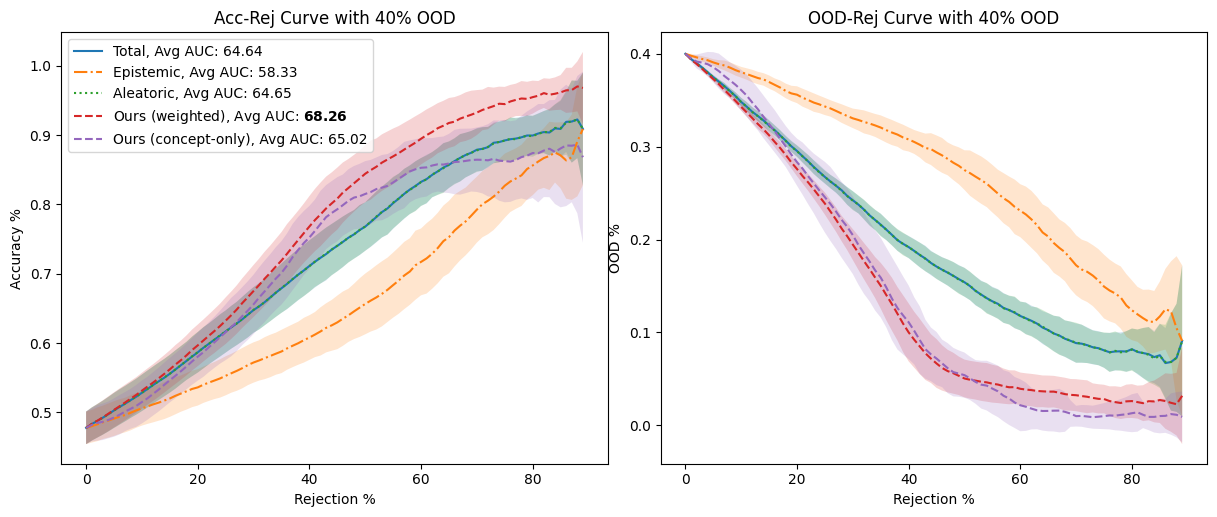

In [1]:
import ast
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load data
df_ood = pd.read_csv("./experiment1_results/curves/40_percent_ood/odd_rej_avg.csv")
df_acc = pd.read_csv("./experiment1_results/curves/40_percent_ood/acc_rej_avg.csv")
auc_df = pd.read_csv('./experiment1_results/auc_results/acc_rej_auc_scores40.csv',index_col='method')

steps = list(range(90))

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Accuracy-Rejection Curve
axes[0].plot(steps, ast.literal_eval(df_acc["total_mean"].values[0]), linestyle="solid", 
             label="Total, Avg AUC: "+ str(np.round(auc_df.iloc[0,:].mean(),2)))
axes[0].fill_between(steps, np.array(ast.literal_eval(df_acc["total_mean"].values[0])) -
                     np.array(ast.literal_eval(df_acc["total_std"].values[0])),
                     np.array(ast.literal_eval(df_acc["total_mean"].values[0])) +
                     np.array(ast.literal_eval(df_acc["total_std"].values[0])), alpha=0.2)

axes[0].plot(steps, ast.literal_eval(df_acc["epistemic_mean"].values[0]), linestyle="dashdot", 
             label="Epistemic, Avg AUC: " +  str(np.round(auc_df.iloc[1,:].mean(),2)))
axes[0].fill_between(steps, np.array(ast.literal_eval(df_acc["epistemic_mean"].values[0])) -
                     np.array(ast.literal_eval(df_acc["epistemic_std"].values[0])),
                     np.array(ast.literal_eval(df_acc["epistemic_mean"].values[0])) +
                     np.array(ast.literal_eval(df_acc["epistemic_std"].values[0])), alpha=0.2)

axes[0].plot(steps, ast.literal_eval(df_acc["aleatoric_mean"].values[0]), linestyle="dotted", 
             label="Aleatoric, Avg AUC: " +  str(np.round(auc_df.iloc[2,:].mean(),2)))
axes[0].fill_between(steps, np.array(ast.literal_eval(df_acc["aleatoric_mean"].values[0])) -
                     np.array(ast.literal_eval(df_acc["aleatoric_std"].values[0])),
                     np.array(ast.literal_eval(df_acc["aleatoric_mean"].values[0])) +
                     np.array(ast.literal_eval(df_acc["aleatoric_std"].values[0])), alpha=0.2)

axes[0].plot(steps, ast.literal_eval(df_acc["hard_weighted-local-1-nmf_mean"].values[0]), linestyle="dashed", 
             label="Ours (weighted), Avg AUC: "+ r"$\bf{"+ str(np.round(auc_df.iloc[15,:].mean(),2))+ "}$")
axes[0].fill_between(steps, np.array(ast.literal_eval(df_acc["hard_weighted-local-1-nmf_mean"].values[0])) -
                     np.array(ast.literal_eval(df_acc["hard_weighted-local-1-nmf_std"].values[0])),
                     np.array(ast.literal_eval(df_acc["hard_weighted-local-1-nmf_mean"].values[0])) +
                     np.array(ast.literal_eval(df_acc["hard_weighted-local-1-nmf_std"].values[0])), alpha=0.2)

axes[0].plot(steps, ast.literal_eval(df_acc["raw-local-1-nmf_mean"].values[0]), linestyle="dashed", 
             label="Ours (concept-only), Avg AUC: "+ str(np.round(auc_df.iloc[23,:].mean(),2)))
axes[0].fill_between(steps, np.array(ast.literal_eval(df_acc["raw-local-1-nmf_mean"].values[0])) -
                     np.array(ast.literal_eval(df_acc["raw-local-1-nmf_std"].values[0])),
                     np.array(ast.literal_eval(df_acc["raw-local-1-nmf_mean"].values[0])) +
                     np.array(ast.literal_eval(df_acc["raw-local-1-nmf_std"].values[0])), alpha=0.2)

axes[0].set_xlabel("Rejection %")
axes[0].set_ylabel("Accuracy %")
axes[0].set_title("Acc-Rej Curve with 40% OOD")
# legend = axes[0].legend(loc='lower right')
axes[0].legend()

# Right: OOD-Rejection Curve
axes[1].plot(steps, ast.literal_eval(df_ood["total_mean"].values[0]), linestyle="solid", label="Total")
axes[1].fill_between(steps, np.array(ast.literal_eval(df_ood["total_mean"].values[0])) -
                     np.array(ast.literal_eval(df_ood["total_std"].values[0])),
                     np.array(ast.literal_eval(df_ood["total_mean"].values[0])) +
                     np.array(ast.literal_eval(df_ood["total_std"].values[0])), alpha=0.2)

axes[1].plot(steps, ast.literal_eval(df_ood["epistemic_mean"].values[0]), linestyle="dashdot", label="Epistemic")
axes[1].fill_between(steps, np.array(ast.literal_eval(df_ood["epistemic_mean"].values[0])) -
                     np.array(ast.literal_eval(df_ood["epistemic_std"].values[0])),
                     np.array(ast.literal_eval(df_ood["epistemic_mean"].values[0])) +
                     np.array(ast.literal_eval(df_ood["epistemic_std"].values[0])), alpha=0.2)

axes[1].plot(steps, ast.literal_eval(df_ood["aleatoric_mean"].values[0]), linestyle="dotted", label="Aleatoric")
axes[1].fill_between(steps, np.array(ast.literal_eval(df_ood["aleatoric_mean"].values[0])) -
                     np.array(ast.literal_eval(df_ood["aleatoric_std"].values[0])),
                     np.array(ast.literal_eval(df_ood["aleatoric_mean"].values[0])) +
                     np.array(ast.literal_eval(df_ood["aleatoric_std"].values[0])), alpha=0.2)

axes[1].plot(steps, ast.literal_eval(df_ood["hard_weighted-local-1-nmf_mean"].values[0]), linestyle="dashed", label="(Ours)")
axes[1].fill_between(steps, np.array(ast.literal_eval(df_ood["hard_weighted-local-1-nmf_mean"].values[0])) -
                     np.array(ast.literal_eval(df_ood["hard_weighted-local-1-nmf_std"].values[0])),
                     np.array(ast.literal_eval(df_ood["hard_weighted-local-1-nmf_mean"].values[0])) +
                     np.array(ast.literal_eval(df_ood["hard_weighted-local-1-nmf_std"].values[0])), alpha=0.2)

axes[1].plot(steps, ast.literal_eval(df_ood["raw-local-1-nmf_mean"].values[0]), linestyle="dashed", label="(Ours)")
axes[1].fill_between(steps, np.array(ast.literal_eval(df_ood["raw-local-1-nmf_mean"].values[0])) -
                     np.array(ast.literal_eval(df_ood["raw-local-1-nmf_std"].values[0])),
                     np.array(ast.literal_eval(df_ood["raw-local-1-nmf_mean"].values[0])) +
                     np.array(ast.literal_eval(df_ood["raw-local-1-nmf_std"].values[0])), alpha=0.2)

axes[1].set_xlabel("Rejection %")
axes[1].set_ylabel("OOD %")
axes[1].set_title("OOD-Rej Curve with 40% OOD")
plt.rcParams.update({'font.size': 1})
# axes[1].legend()

plt.tight_layout()
# plt.savefig("./rejection_w_ood/nmf_only/var/figs/fig_for_paper",dpi=330)
plt.show()

In [2]:
auc_df.iloc[0,:]

0     64.964127
1     63.889924
2     61.738331
3     64.194708
4     66.608448
5     67.854508
6     64.137884
7     64.423092
8     61.418303
9     66.783951
10    64.267888
11    67.354666
12    63.229713
13    60.580026
14    64.882044
15    67.264505
16    65.152959
17    66.998140
18    68.588806
19    58.510274
Name: total, dtype: float64

In [3]:
auc_df.iloc[15,:]

0     67.985052
1     67.989091
2     65.564299
3     68.491231
4     69.983677
5     71.373099
6     68.127483
7     68.953778
8     64.545639
9     68.823267
10    69.841316
11    69.152568
12    66.074593
13    65.219408
14    67.907587
15    70.295233
16    69.078933
17    71.140347
18    73.249644
19    61.471491
Name: hard_weighted-local-1-nmf, dtype: float64

In [4]:
from scipy import stats
sample1 = auc_df.iloc[0,:].to_numpy()
sample2 = auc_df.iloc[15,:].to_numpy()
stats.wilcoxon(sample2, sample1, alternative="two-sided")

WilcoxonResult(statistic=np.float64(0.0), pvalue=np.float64(1.9073486328125e-06))

In [5]:
df_a = auc_df.mean(axis=1)
df_a


method
total                        64.642115
epistemic                    58.334938
aleatoric                    64.647212
var                          65.730852
kl                           64.642115
sigmoid-mapping              64.660927
soft_weighted-local-1-imp    52.366582
soft_weighted-local-1-nmf    67.275118
soft_weighted-local-2-imp    53.563259
soft_weighted-local-2-nmf    66.667597
soft_weighted-local-3-imp    54.112051
soft_weighted-local-3-nmf    65.712794
soft_weighted-local-5-imp    54.570135
soft_weighted-local-5-nmf    63.893492
hard_weighted-local-1-imp    56.420380
hard_weighted-local-1-nmf    68.263387
hard_weighted-local-2-imp    56.640822
hard_weighted-local-2-nmf    68.407286
hard_weighted-local-3-imp    56.747030
hard_weighted-local-3-nmf    67.985504
hard_weighted-local-5-imp    56.567964
hard_weighted-local-5-nmf    66.684979
raw-local-1-imp              42.761451
raw-local-1-nmf              65.016417
raw-local-2-imp              43.112832
raw-local-2-nmf   

In [6]:
df_s = auc_df.std(axis=1)
df_s

method
total                        2.622632
epistemic                    3.141510
aleatoric                    2.631061
var                          2.579078
kl                           2.622632
sigmoid-mapping              2.637686
soft_weighted-local-1-imp    2.961692
soft_weighted-local-1-nmf    2.933915
soft_weighted-local-2-imp    3.063972
soft_weighted-local-2-nmf    2.923051
soft_weighted-local-3-imp    3.046385
soft_weighted-local-3-nmf    2.737547
soft_weighted-local-5-imp    3.127833
soft_weighted-local-5-nmf    2.794342
hard_weighted-local-1-imp    2.744292
hard_weighted-local-1-nmf    2.678141
hard_weighted-local-2-imp    3.026242
hard_weighted-local-2-nmf    2.653344
hard_weighted-local-3-imp    2.997294
hard_weighted-local-3-nmf    2.436317
hard_weighted-local-5-imp    3.121580
hard_weighted-local-5-nmf    2.451131
raw-local-1-imp              2.554329
raw-local-1-nmf              3.249374
raw-local-2-imp              2.535837
raw-local-2-nmf              3.258583
raw-l